In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from tqdm import tqdm
import seaborn
import spacy
from scipy import stats
from collections import defaultdict

tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

In [3]:
# Load all generated captions
vistext_captions_df = pd.read_json("./vistext_eval/vistext_id_to_combined_captions.jsonl", orient='records', lines=True)
gallery_captions_df = pd.read_json("./matplotlib_gallery/mpl_gallery_combined_captions_shuffled.jsonl", orient='records', lines=True)
gallery_captions_df.rename(columns={'figure_id': 'image_id', 'gpt-4-turbo-L3-225': "gpt-4-turbo-L3",
                                    "gpt-4-turbo-alt-L3-225": "gpt-4-turbo-alt-L3"}, inplace=True)
# Load similarities to human captions
vistext_similarity_scores = np.load("./vistext_id_to_sim_scores.npy", allow_pickle=True).item()
# Convert similarity scores to dataframe
vistext_similarity_scores_df = []
for img_id in vistext_similarity_scores:
    sim_scores_dict = {"image_id": img_id}
    for cap_type, cap_sim_scores in vistext_similarity_scores[img_id].items():
        sim_scores_dict[cap_type + "_sim_scores"] = cap_sim_scores
    vistext_similarity_scores_df.append(sim_scores_dict)
vistext_similarity_scores_df = pd.DataFrame(vistext_similarity_scores_df)
# Load blipscores
vistext_blipscores = pd.read_json("./vistext_blipscores.jsonl", orient='records', lines=True)
gallery_blipscores = pd.read_json("./gallery_blipscores.jsonl", orient='records', lines=True)
vistext_blipscores.rename(columns={'figure_id': 'image_id'}, inplace=True)
gallery_blipscores.rename(columns={'figure_id': 'image_id', "gpt-4-turbo-L3-225-prob": "gpt-4-turbo-L3-prob",
                                   "gpt-4-turbo-alt-L3-225-prob": "gpt-4-turbo-alt-L3-prob",
                                   "gpt-4-turbo-L3-225-cos-sim": "gpt-4-turbo-L3-cos-sim",
                                   "gpt-4-turbo-alt-L3-225-cos-sim": "gpt-4-turbo-alt-L3-cos-sim"}, inplace=True)
# Load manually annotated errors
vistext_errors = pd.read_csv("./vistext_error_annotations.tsv", sep='\t', header=0)
gallery_errors = pd.read_csv("./gallery_error_annotations.tsv", sep='\t', header=0)
vistext_errors = vistext_errors.drop("Notes", axis=1)
vistext_errors.fillna("correct", inplace = True)
vistext_errors.rename(columns={'Image ID': 'image_id', 'Heuristic': "heuristic_errors",
                               "turbo L3": "gpt-4-turbo-L3_errors",
                               "turbo heuristic L3": "gpt-4-turbo-alt-L3_errors",
                               "turbo table L3": "gpt-4-turbo-table-L3_errors",
                               "turbo heuristic + table L3": "gpt-4-turbo-table-alt-L3_errors",
                               "Chart type": "chart_type"
                               }, inplace=True)
gallery_errors = gallery_errors.drop("Notes", axis=1)
gallery_errors.rename(columns={'Image ID': 'image_id', 'Heuristic': "heuristic_errors",
                               "turbo L3": "gpt-4-turbo-L3_errors",
                               "turbo heuristic L3": "gpt-4-turbo-alt-L3_errors",
                               "Chart type": "chart_type",
                               "Num subplots": "num_subplots"
                               }, inplace=True)
print(vistext_similarity_scores[9]['gpt-4-turbo-L3'].keys())
#print(vistext_errors.columns)
#print(gallery_errors.columns)

dict_keys(['rouge1_p', 'rouge1_r', 'rouge1_f1', 'rouge2_p', 'rouge2_r', 'rouge2_f1', 'rougeL_p', 'rougeL_r', 'rougeL_f1', 'rougeLsum_p', 'rougeLsum_r', 'rougeLsum_f1', 'bleu', 'chrf', 'bleurt', 'bertscore_p', 'bertscore_r', 'bertscore_f1'])


In [4]:
# Merge everything together
vistext_combined_stats_df = vistext_captions_df.copy()
gallery_combined_stats_df = gallery_captions_df.copy()
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_blipscores, on="image_id", how="outer")
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_errors, on="image_id", how="outer")
vistext_combined_stats_df = vistext_combined_stats_df.merge(right=vistext_similarity_scores_df, on="image_id", how="outer")
gallery_combined_stats_df = gallery_combined_stats_df.merge(right=gallery_blipscores, on="image_id", how="outer")
gallery_combined_stats_df = gallery_combined_stats_df.merge(right=gallery_errors, on="image_id", how="outer")
vistext_combined_stats_df["num_subplots"] = 1
vistext_combined_stats_df["dataset"] = "vistext"
gallery_combined_stats_df["dataset"] = "gallery"
combined_stats_df = pd.concat([vistext_combined_stats_df, gallery_combined_stats_df])
combined_stats_df.to_json("./combined_stats.jsonl", orient='records', lines=True)
print(len(combined_stats_df), combined_stats_df.columns)

1084 Index(['image_id', 'human', 'heuristic', 'gpt-4-turbo-L4',
       'gpt-4-turbo-alt-L4', 'gpt-4-turbo-table-L4', 'gpt-4-turbo-L3',
       'gpt-4-turbo-alt-L3', 'gpt-4-turbo-table-L3',
       'gpt-4-turbo-table-alt-L3', 'human-prob', 'heuristic-prob',
       'gpt-4-turbo-L4-prob', 'gpt-4-turbo-alt-L4-prob',
       'gpt-4-turbo-table-L4-prob', 'gpt-4-turbo-L3-prob',
       'gpt-4-turbo-alt-L3-prob', 'gpt-4-turbo-table-L3-prob',
       'gpt-4-turbo-table-alt-L3-prob', 'human-cos-sim', 'heuristic-cos-sim',
       'gpt-4-turbo-L4-cos-sim', 'gpt-4-turbo-alt-L4-cos-sim',
       'gpt-4-turbo-table-L4-cos-sim', 'gpt-4-turbo-L3-cos-sim',
       'gpt-4-turbo-alt-L3-cos-sim', 'gpt-4-turbo-table-L3-cos-sim',
       'gpt-4-turbo-table-alt-L3-cos-sim', 'heuristic_errors',
       'gpt-4-turbo-L3_errors', 'gpt-4-turbo-alt-L3_errors',
       'gpt-4-turbo-table-L3_errors', 'gpt-4-turbo-table-alt-L3_errors',
       'chart_type', 'heuristic_sim_scores', 'gpt-4-turbo-L3_sim_scores',
       'gpt-4-turbo-

In [5]:
sim_L3_caption_types = ["heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                        "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
sim_metric_to_arr = defaultdict(list)
sim_cap_lens = []
def get_sim_stat_arrs(row):
    for cap_type in sim_L3_caption_types:
        caption = row[cap_type]
        cap_sim_scores = row[f"{cap_type}_sim_scores"]
        if caption is not None and isinstance(cap_sim_scores, dict):
            if isinstance(caption, list) and len(caption) == 1:
                caption = caption[0]
            sim_cap_lens.append(len([token.text for token in nlp(caption)]))
            for metric_name, scores in cap_sim_scores.items():
                sim_metric_to_arr[metric_name].append(np.mean(scores))

combined_stats_df.progress_apply(get_sim_stat_arrs, axis=1)
sim_metric_to_arr["lens"] = sim_cap_lens
np.save("./caption_sim_metric_to_arr", sim_metric_to_arr)

100%|██████████| 1084/1084 [01:27<00:00, 12.32it/s]


Text(0.5, 0, 'Description length (tokens)')

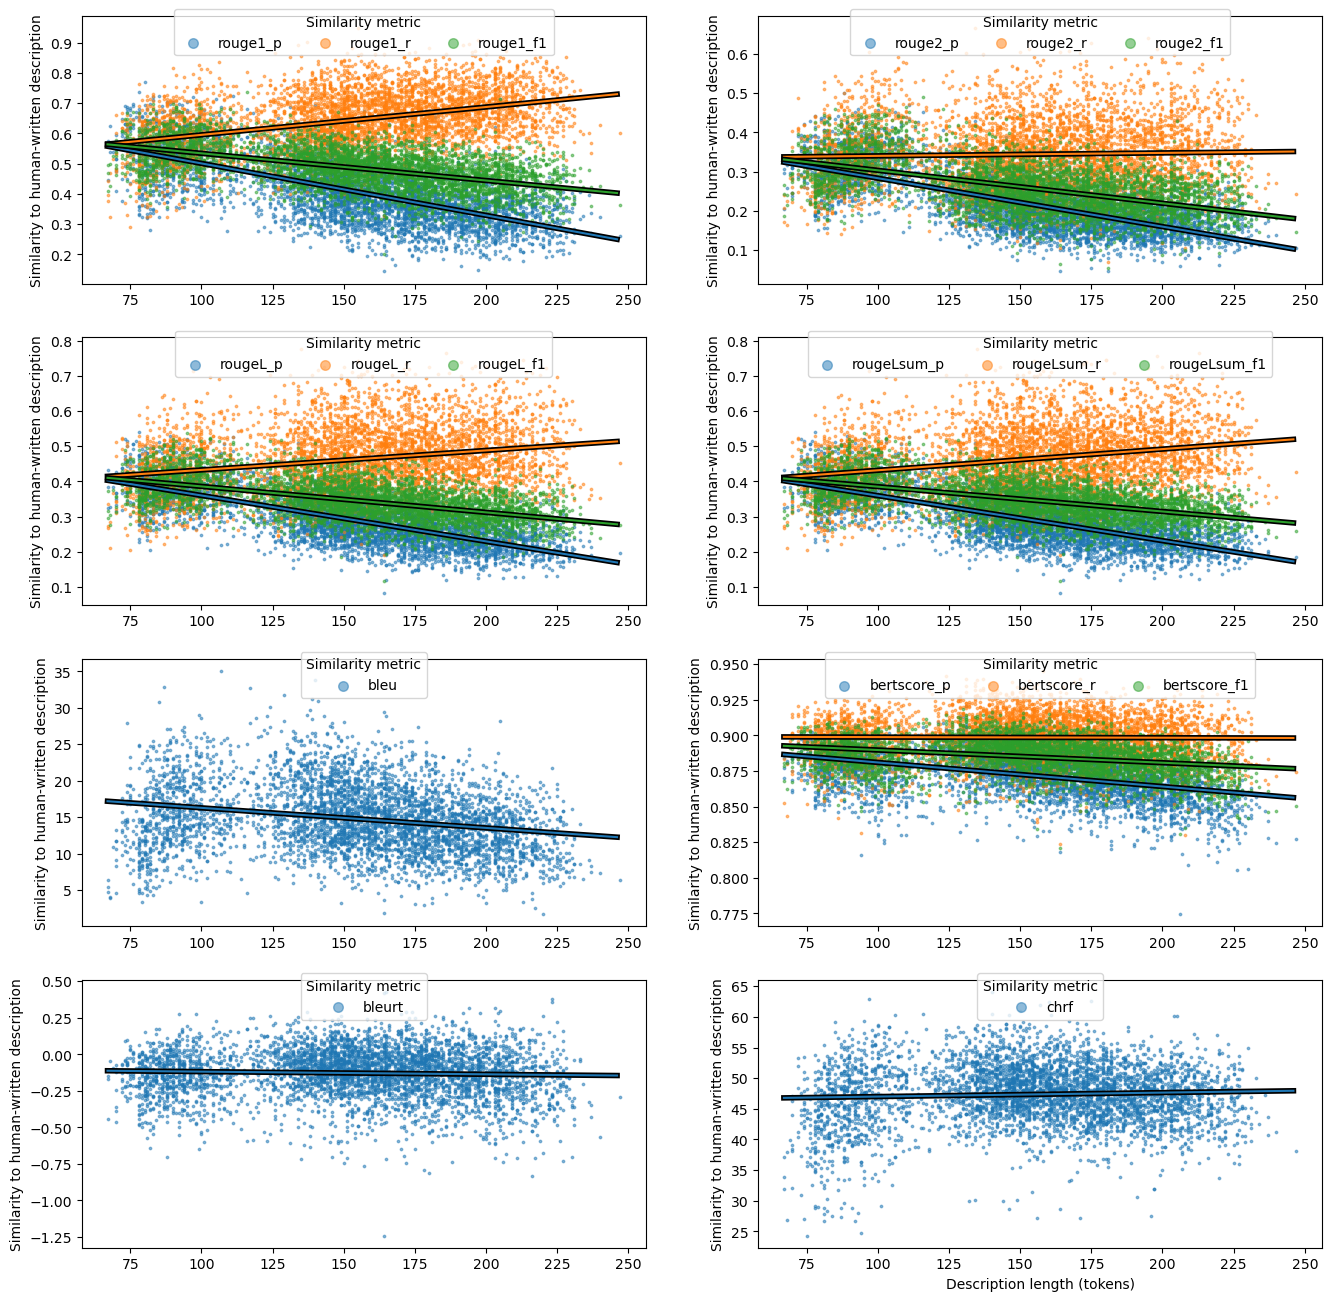

In [38]:
len_linear_fits = np.load("./len_linear_fits.npy", allow_pickle=True).item()
xs = np.array(list(range(np.min(sim_cap_lens), np.max(sim_cap_lens))))

metric_groups = ["rouge1", "rouge2", "rougeL", "rougeLsum", "bleu", "bertscore", "bleurt", "chrf"]

fig, axs = plt.subplots(ncols=2, nrows=(len(metric_groups) // 2), figsize=(16, 2*len(metric_groups)))
axs = axs.flatten()

for midx, mgroup in enumerate(metric_groups):
    for metric_name, cap_scores in sim_metric_to_arr.items():
        if metric_name.startswith(mgroup + "_") or metric_name == mgroup:
            axs[midx].scatter(sim_cap_lens, cap_scores, label=metric_name, s=3, alpha=0.5)
            metric_linear_fit = len_linear_fits["human_sim"][metric_name]
            axs[midx].plot(xs, metric_linear_fit.intercept + metric_linear_fit.slope * xs, path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    axs[midx].set_ylabel("Similarity to human-written description")
    axs[midx].legend(title="Similarity metric", loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, markerscale=4)
axs[-1].set_xlabel("Description length (tokens)")

In [8]:
sim_L3_caption_types = ["human", "heuristic", "gpt-4-turbo-L3", "gpt-4-turbo-alt-L3",
                        "gpt-4-turbo-table-L3", "gpt-4-turbo-table-alt-L3"]
blip_cap_lens = []
blip_probs = []
blip_cos_sims = []
def get_blip_stat_arrs(row):
    for cap_type in sim_L3_caption_types:
        if cap_type in row:
            captions = row[cap_type]
            if isinstance(captions, (str, list)):
                if isinstance(captions, str):
                    captions = [captions]
                cap_probs = row[f"{cap_type}-prob"]
                cap_cos_sims = row[f"{cap_type}-cos-sim"]
                if isinstance(cap_probs, float):
                    cap_probs = [cap_probs]
                if isinstance(cap_cos_sims, float):
                    cap_cos_sims = [cap_cos_sims]
                if isinstance(captions, str):
                    captions = [captions]
                for cap_idx, caption in enumerate(captions):
                    blip_cap_lens.append(len([token.text for token in nlp(caption)]))
                    blip_probs.append(cap_probs[cap_idx])
                    blip_cos_sims.append(cap_cos_sims[cap_idx])

combined_stats_df.progress_apply(get_blip_stat_arrs, axis=1)
np.save("./caption_blip_metric_to_arr", {"lens": blip_cap_lens, "probs": blip_probs,
                                         "cos_sims": blip_cos_sims})

100%|██████████| 1084/1084 [01:54<00:00,  9.50it/s]


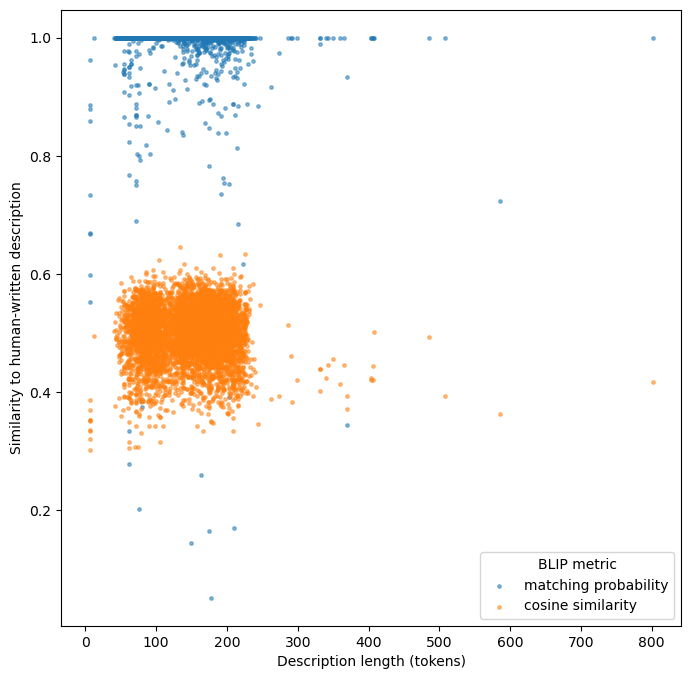

In [23]:
plt.gcf().set_size_inches(8, 8)
plt.scatter(blip_cap_lens, blip_probs, label="matching probability", s=6, alpha=0.5)
plt.scatter(blip_cap_lens, blip_cos_sims, label="cosine similarity", s=6, alpha=0.5)
plt.xlabel("Description length (tokens)")
plt.ylabel("Similarity to human-written description")
plt.legend(title="BLIP metric")